# Kampff lab - Polytrode Impedance


Here a description of the dataset:
http://www.kampff-lab.org/polytrode-impedance

Here the official publication of this open dataset:
https://crcns.org/data-sets/methods/evi-1/about-evi-1

And the citation:
Joana P Neto, Pedro Baião, Gonçalo Lopes, João Frazão, Joana Nogueira, Elvira Fortunato, Pedro Barquinha, Adam R Kampff (2018); Extracellular recordings using a dense electrode array allowing direct comparison of the same neural signal measured with low and high impedance electrodes CRCNS.org
http://dx.doi.org/10.6080/K07M064M

And a paper on results in Frontier
https://doi.org/10.3389/fnins.2018.00715

## Introduction


For this study they use polytrode aranged in chess board so that 16 of electrodes have a 1Mohm (at 1kHz) impedance and other 16 have 100kohm impedance.

The goal of this is notebook is to reproduce the spike sorting pipeline on the dataset.

In the official paper in frontier, Joana Neto and co, use kilosort for spike sorting but no public report the result of the dataset.

Here is a replicate and reproducible pipeline with tridesclous.

This is done only on one file **amplifier2017-02-02T17_18_46** but the same script can be applied easly on other files form teh same dataset.

## Download

Dataset must downloaded locally and manually from crcns or from the google drive in **"workdir"** path.



## The PRB file
tridesclous need a PRB file that describe the geometry of probe.

Create it by copy/paste or download it via github.

Here I split the probe in 3 groups : 
  * **0** is all channel
  * **1** is 1Mohm electrodes
  * **2** is 100kohm electrodes

So we could test tridesclous on all channels or one or the other impedance.

```python
channel_groups = {
    0: {
        'channels':  [0, 31, 24, 7, 1, 21, 10, 30, 25, 6, 15, 20, 11, 16, 26, 5,
                        14, 19, 12, 17, 27, 4, 8, 18, 13, 23, 28, 3, 9, 29, 2, 22],
        'graph' : [],
        'geometry': {
            0: [18.0, 0.0],
            31: [18.0, 25.],
            24: [0.0, 37.5],
            7: [36.0, 37.5],
            1: [18.0, 50.],
            21: [0.0, 62.5],
            10: [36., 62.5],
            30: [18.0, 75.0],
            25: [0.0, 87.5],
            6: [36.0, 87.5],
            15: [18.0, 100.0],
            20: [0.0, 112.5],
            11: [36.0, 112.5],
            16: [18.0, 125.0],
            26: [0.0, 137.5],
            5: [36.0, 137.5],
            14: [18.0, 150.0],
            19: [0.0, 162.5],
            12: [36.0, 162.5],
            17: [18.0, 175.0],
            27: [0.0, 187.5],
            4: [36.0, 187.5],
            8: [18.0, 200.0],
            18: [0.0, 212.5],
            13: [36.0, 212.5],
            23: [18.0, 225.0],
            28: [0.0, 237.5],
            3: [36.0, 237.5],
            9: [18.0, 250.0],
            29: [0.0, 262.5],
            2: [36.0, 262.5],
            22: [18.0, 275.0],
        },
    },
    1: {
        'channels':  [0, 24, 1, 10, 25, 15, 11, 26, 14, 12, 27, 8, 13, 28, 9, 2],
        'graph' : [],
        'geometry': {
            0: [18.0, 0.0],
            24: [0.0, 37.5],
            1: [18.0, 50.],
            10: [36., 62.5],
            25: [0.0, 87.5],
            15: [18.0, 100.0],
            11: [36.0, 112.5],
            26: [0.0, 137.5],
            14: [18.0, 150.0],
            12: [36.0, 162.5],
            27: [0.0, 187.5],
            8: [18.0, 200.0],
            13: [36.0, 212.5],
            28: [0.0, 237.5],
            9: [18.0, 250.0],
            2: [36.0, 262.5],
        }
    },
    2: {
        'channels':  [31, 7, 21, 30, 6, 20, 16, 5, 19, 17, 4, 18, 23, 3, 29, 22],
        'graph' : [],
        'geometry': {
            31: [18.0, 25.0],
            7: [36.0, 37.5],
            21: [0.0, 62.5],
            30: [18.0, 75.0],
            6: [36.0, 87.5],
            20: [0.0, 112.5],
            16: [18.0, 125.0],
            5: [36.0, 137.5],
            19: [0.0, 162.5],
            17: [18.0, 175.0],
            4: [36.0, 187.5],
            18: [0.0, 212.5],
            23: [18.0, 225.0],
            3: [36.0, 237.5],
            29: [0.0, 262.5],
            22: [18.0, 275.0],
        }
    }
}
```

In [1]:
# suposing the datset is downloaded here
# workdir = '/media/samuel/dataspikesorting/DataSpikeSortingHD2/kampff/polytrode Impedance/'
workdir = '/home/samuel/Documents/projet/DataSpikeSorting/kampff/polytrode Impedance/'

# Input file
filename = workdir + 'amplifier2017-02-02T17_18_46/amplifier2017-02-02T17_18_46.bin'

# dirname is where tridesclous will put eveything
dirname = workdir + 'tdc_amplifier2017-02-02T17_18_46'


In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import tridesclous as tdc
from tridesclous import DataIO, CatalogueConstructor, Peeler
import os, shutil

## create a DataIO (and remove if already exists)

In [3]:
if os.path.exists(dirname):
    #remove is already exists to restart from stractch
    shutil.rmtree(dirname)
    
dataio = DataIO(dirname=dirname)

# feed DataIO with one file
dataio.set_data_source(type='RawData', filenames=[filename],
                    sample_rate=20000., dtype='uint16', total_channel=32,
                    bit_to_microVolt=0.195)

print(dataio)

# set the probe file
dataio.set_probe_file('kampff_polytrode_impedance_32.prb')

DataIO <id: 140180292735832> 
  workdir: /home/samuel/Documents/projet/DataSpikeSorting/kampff/polytrode Impedance/tdc_amplifier2017-02-02T17_18_46
  sample_rate: 20000.0
  total_channel: 32
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch28 ch29 ch30 ch31]
  nb_segment: 1
  length: 6958592
  durations: 347.9 s.


## CatalogueConstructor

Make catalogue on the first 280. After this the signal is totally noisy.

In [4]:
cc = CatalogueConstructor(dataio=dataio, chan_grp=0)

cc.set_preprocessor_params(chunksize=1024, common_ref_removal=False,
            highpass_freq=250., lowpass_freq=9500.,                                             
            peak_sign='-', relative_threshold=5., peak_span=0.0001)

cc.estimate_signals_noise(duration=30.)
cc.run_signalprocessor(duration=280.)
cc.extract_some_waveforms(n_left=-15, n_right=20, mode='rand', nb_max=20000)
cc.clean_waveforms(alien_value_threshold=100.)
cc.extract_some_features(method='peak_max')
cc.find_clusters(method='sawchaincut', kde_bandwith=1.0)

print(cc)


order_clusters waveforms_rms
CatalogueConstructor
  chan_grp 0 - ch0 ch31 ch24 ... ch2 ch22
  nb_peak_by_segment: 24031
  some_waveforms.shape: (13602, 35, 32)
  some_features.shape: (13602, 32)
  cluster_labels [-11  -1   0   1   2   3]



## Noise measurement

This is done with the [MAD](https://en.wikipedia.org/wiki/Median_absolute_deviation) a robust variance.

mad = median(abs(x-median(x)) * 1.4826



In [8]:
dataio = DataIO(dirname=dirname)
tdc.summary_noise(dataio=dataio, chan_grp=0)


Noise mesured with mesured with MAD (=robust STD)
  Channel group 0
  Nb_channel:  32
  Noise range: 4.91 - 8.43 μV
  By channel noise: [7.1 4.9 7.1 5.0 ... 7.6 5.4 8.4 5.3] μV
  Average noise along channel: 6.591325759887695  μV
  Threshold:  5.0 *MAD = 32.95662879943848 μV



## Inspect waveform quality at catalogue level


Cluster 0
Max on channel (abs): 20
Max on channel (local to group): 11
Peak amplitude MAD: -29.332443237304688
Peak amplitude (µV): -163.52842028150567




<IPython.core.display.Javascript object>


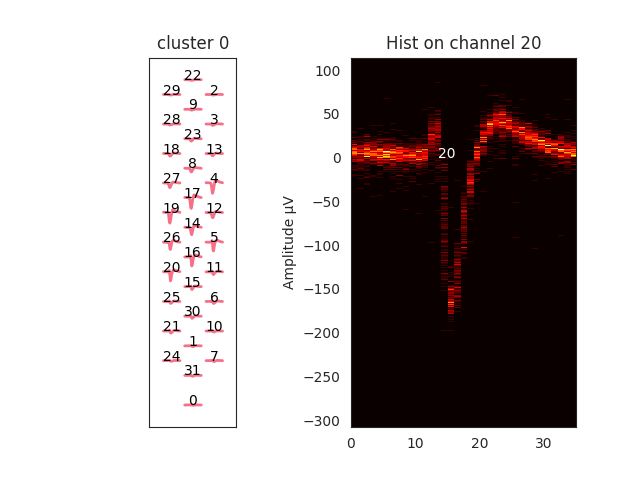

In [10]:
tdc.summary_catalogue_clusters(dataio=dataio, chan_grp=0, label=0)

## construct catalogue

In [11]:
cc.make_catalogue_for_peeler()

make_catalogue 0.413810755000668


## apply peeler

This is the real spike sorting: find spike that correcpond to catalogue templates.

This is done in **51 s.** on my old laptop (Intel i5-3337U) without opencl.


In [12]:
initial_catalogue = dataio.load_catalogue(chan_grp=0)
peeler = Peeler(dataio)
peeler.change_params(catalogue=initial_catalogue)
peeler.run(duration=None, progressbar=True)

100%|██████████| 6795/6795 [00:51<00:00, 132.64it/s]


# final inspection of cells

<IPython.core.display.Javascript object>


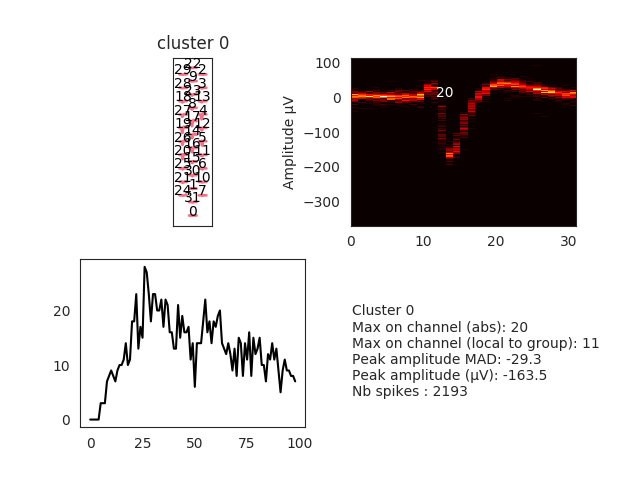


Cluster 0
Max on channel (abs): 20
Max on channel (local to group): 11
Peak amplitude MAD: -29.3
Peak amplitude (µV): -163.5
Nb spikes : 2193




In [13]:
tdc.summary_after_peeler_clusters(dataio, chan_grp=0,  label=0)